In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.rsot.problem import RSOT, EntropicRSOT
from src.rsot.sinkhorn import calc_U, calc_k_formula, robust_semisinkhorn_eps
from src.utils import norm_inf

import time

In [2]:
# Dimension
n = 100

# Regularization
tau = np.float64(1.0)

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(1.0, 50.0, (n, n)).astype(np.float64)

# Marginal vectors
a = np.random.uniform(0.1, 1.0, n).astype(np.float64)
b = np.random.uniform(0.1, 1.0, n).astype(np.float64)

a = a / a.sum()
b = b / b.sum()

# Varying $\epsilon$

In [ ]:
# Original UOT problem
rsot = RSOT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_rsot(rsot)

print('Optimal:', f_optimal)

In [ ]:
# Number of eps
neps = 30

# Epsilons
eps_arr = np.logspace(start=-1, stop=-5, num=neps).astype(np.float64)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    print(f'Epsilon {i}:', eps)
    start = time.time()

    # Entropic regularization parameter
    U = calc_U(rsot, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    ersot = EntropicRSOT(C, a, b, tau, eta)

    # Sinkhorn
    _, log = robust_semisinkhorn_eps(ersot, f_optimal, eps, 
                                     patience=1000,
                                     save_uv=False, verbose=True)
    
    plt.plot(log['f'][1:])
    plt.axhline(f_optimal, color='red')
    plt.show()

    # Find k
    kfs[i] = calc_k_formula(ersot, eps)
    kcs[i] = len(log['f']) - 1000

    print('Time elapsed:', time.time() - start)
    print('=================')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

ax[0].plot(np.log(1 / eps_arr), np.log(kcs), marker='.', label='$\log k_c$')
ax[0].plot(np.log(1 / eps_arr), np.log(kfs), marker='.', label='$\log k_f$')
ax[0].legend()

ax[1].plot(np.log(1 / eps_arr), kfs / kcs, marker='.', label='$k_f$ / $k_c$')
ax[1].legend()

# Theory checking

In [4]:
# Original UOT problem
rsot = RSOT(C, a, b, tau)

In [6]:
# Optimal solution for RSOT
X_hat = rsot.optimize_f('SCS')

f_hat = rsot.calc_f(X_hat)

print('Optimal:', f_hat)

Optimal: 1.7833128682547006


In [7]:
# Entropic regularization parameter
eta = np.float64(0.0)

# Convert to Entropic Regularized UOT
ersot = rsot.entropic_regularize(eta)

In [8]:
# Optimal solution for EntropicRSOT
X_star = ersot.optimize_g_primal('SCS')

f_star = ersot.calc_f(X_star)
g_star = ersot.calc_g(X_star)

print('Optimal:', f_star, g_star)

Optimal: 1.78502959959134 1.78502959959134


In [9]:
# Optimal solution for EntropicRSOT (dual)
u_star, v_star = ersot.optimize_g_dual(solver='SCS')
X_star_dual = ersot.calc_B(u_star, v_star)

f_star_dual = ersot.calc_f(X_star_dual)
g_star_dual = ersot.calc_g(X_star_dual)

print('Optimal:', f_star_dual, g_star_dual)

WARN: A->p (column pointers) not strictly increasing, column 10100 empty
WARN: A->p (column pointers) not strictly increasing, column 10101 empty
WARN: A->p (column pointers) not strictly increasing, column 10102 empty
WARN: A->p (column pointers) not strictly increasing, column 10103 empty
WARN: A->p (column pointers) not strictly increasing, column 10104 empty
WARN: A->p (column pointers) not strictly increasing, column 10105 empty
WARN: A->p (column pointers) not strictly increasing, column 10106 empty
WARN: A->p (column pointers) not strictly increasing, column 10107 empty
WARN: A->p (column pointers) not strictly increasing, column 10108 empty
WARN: A->p (column pointers) not strictly increasing, column 10109 empty
WARN: A->p (column pointers) not strictly increasing, column 10110 empty
WARN: A->p (column pointers) not strictly increasing, column 10111 empty
WARN: A->p (column pointers) not strictly increasing, column 10112 empty
WARN: A->p (column pointers) not strictly increasin

TypeError: 'NoneType' object is not subscriptable

In [13]:
eps = 0.001

# Entropic regularization parameter
U = calc_U(rsot, eps)
eta = eps / U

# Convert to Entropic Regularized UOT
ersot = rsot.entropic_regularize(eta)

start = time.time()

# Sinkhorn
_, log = robust_semisinkhorn_eps(ersot, f_star, eps, 
                                 save_uv=False,
                                 patience=1000, verbose=True)

print('Time elapsed:', time.time() - start)

0 1.0000000000000002
1000 2.004183933836871
2000 1.9869413251634482
3000 1.977996531431473
4000 1.9433800964810761
5000 1.8941222330035403
6000 1.8645035776600225
7000 1.8509278202030883
8000 1.8467705317678382
9000 1.8355864114757083
10000 1.8207923518496758
11000 1.8156642594111434
12000 1.8104716174307556
13000 1.8006722582916133
14000 1.7965106196905647
15000 1.7938910603961267
16000 1.7934864887688613
17000 1.7920289644816074
18000 1.7918648138742512
19000 1.7918647759163393
20000 1.7918647716997982
21000 1.791022424633093
22000 1.7905438862199436
23000 1.7881164455041583
24000 1.7859869785934277
24998 1.7857072704988062
Time elapsed: 24.005887985229492


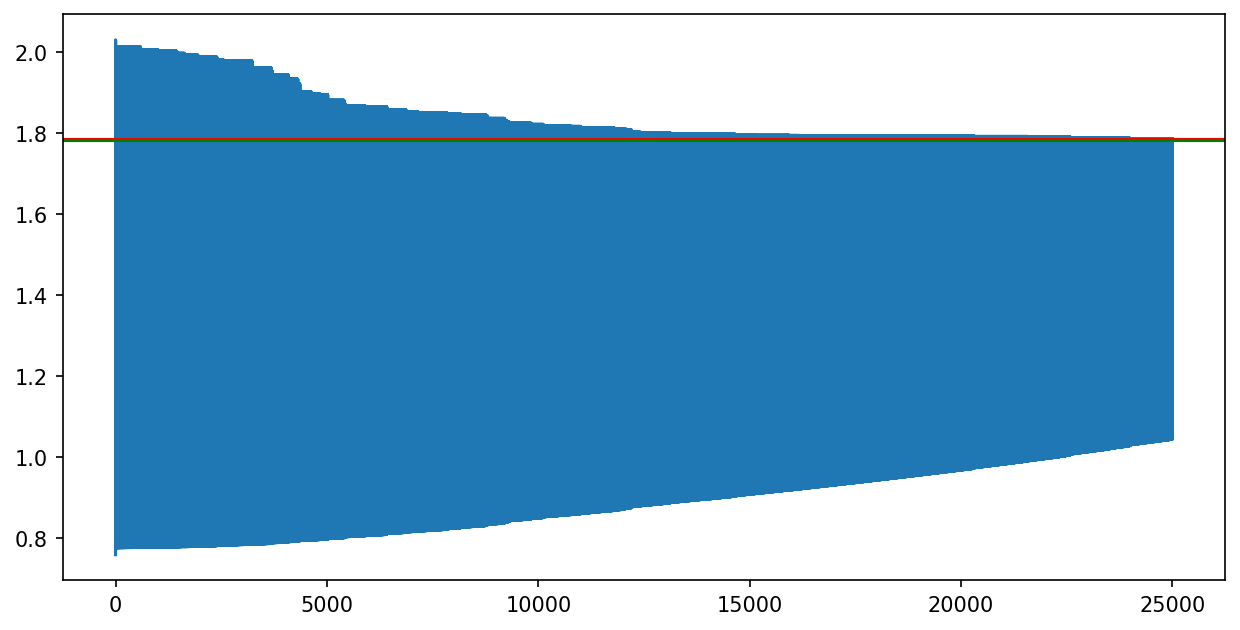

In [18]:
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(log['f'][1:])
plt.axhline(f_star, color='red')
plt.axhline(f_hat, color='green')
plt.show()

In [ ]:
y = []

for uk, vk in zip(log['u'], log['v']):
    Xk = calc_B(ersot, uk, vk)
    # y.append(norm_inf(Xk - X_hat))
    y.append(calc_g_rsot(ersot, Xk))

plt.plot(y)